In [2]:
%pylab inline
import faiss
import pandas as pd
import os
import glob
import scipy 
from scipy import signal
#from riboraptor.helpers import mkdir_p, path_leaf
#from riboraptor.coherence import coherence
import scipy.cluster.hierarchy as hac

from pysradb.sradb import SRAdb
import faiss                   # make faiss available
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_context('talk', font_scale=2)
sns.set_style('white')

import ntpath
def path_leaf(path):
    """Get path's tail from a filepath"""
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)
def coherence(original_values, frames=[0]):
    """Calculate coherence and an idea ribo-seq signal

    Parameters
    ----------
    values : array like
             List of values

    Returns
    -------
    periodicity : float
                  Periodicity score calculated as
                  coherence between input and idea 1-0-0 signal

    f: array like
       List of frequencies

    Cxy: array like
         List of coherence at the above frequencies

    """
    if not isinstance(original_values, list):
        original_values = list(original_values)
    coh, pval, valid = 0.0, 1.0, -1
    final_individual_angles =  []
    final_angle =  np.nan
    final_coherence_raw = np.nan
    final_unit_vector_real = []
    final_unit_vector_imag = []
    thetas = []
    for frame in frames:
        unit_vectors_real = []
        unit_vectors_imag = []
        values = original_values[frame:]
        normalized_values = []
        i = 0
        while i + 2 < len(values):
            if values[i] == values[i + 1] == values[i + 2] == 0:
                i += 3
                continue
            real = values[i] + values[i + 1] * np.cos(
                2 * np.pi / 3) + values[i + 2] * np.cos(4 * np.pi / 3)
            imag = values[i + 1] * np.sin(
                2 * np.pi / 3) + values[i + 2] * np.sin(4 * np.pi / 3)
            norm = np.sqrt(real**2 + imag**2)
            if norm == 0:
                norm = 1
            unit_vectors_real += [real/norm]
            unit_vectors_imag  += [imag/norm]
            normalized_values += [
                values[i] / norm, values[i + 1] / norm, values[i + 2] / norm
            ]
            i += 3
        unit_vectors_real = np.array(unit_vectors_real)
        unit_vectors_imag = np.array(unit_vectors_imag)

        length = len(normalized_values) // 3 * 3
        if length == 0:
            return coh, pval, valid, final_coherence_raw, final_angle, final_individual_angles, final_unit_vector_real, final_unit_vector_imag
        normalized_values = normalized_values[:length]
        uniform_signal = [1, 0, 0] * (len(normalized_values) // 3)
        f, Cxy = signal.coherence(
            normalized_values,
            uniform_signal,
            window=[1.0, 1.0, 1.0],
            nperseg=3,
            noverlap=0)

        coherence_raw = np.nanmean(unit_vectors_real)**2 + np.nanmean(unit_vectors_imag)**2
        individual_angles = np.arctan2(unit_vectors_imag, unit_vectors_real)
        combine_angle = np.arctan2(np.sum(unit_vectors_imag), np.sum(unit_vectors_real))
        try:
            periodicity_score = Cxy[np.argwhere(np.isclose(f, 1 / 3.0))[0]][0]
            periodicity_pval = coherence_pvalue(periodicity_score, length // 3)
        except:
            periodicity_score = 0.0
            periodicity_pval = 1.0

        if coherence_raw > coh:
            final_individual_angles =  individual_angles
            final_angle = combine_angle
            final_coherence_raw = coherence_raw
            final_unit_vector_real = unit_vectors_real
            final_unit_vector_imag = unit_vectors_imag

            #coh = periodicity_score
            coh = coherence_raw
            pval = periodicity_pval
            valid = length
        if valid == -1:
            valid = length
    return coh, pval, valid, final_coherence_raw, final_angle, final_individual_angles, final_unit_vector_real, final_unit_vector_imag

Populating the interactive namespace from numpy and matplotlib


In [3]:
COH_CUTOFF = 0.428571428571
METAGENE_DIMENSION = 600
sradb  = SRAdb('/staging/as/skchoudh/SRAmetadb.sqlite')

In [4]:
def find_all_metagene_profiles(root_dir = '/staging/as/skchoudh/re-ribo-analysis/'):
    datasets = glob.glob(os.path.join(root_dir, '*', '*', 'ribocop_results', '*_metagene_profiles_5p.tsv'))
    return datasets

def get_coherence(profile):
    coh, pval, valid, final_coherence_raw, final_angle, final_individual_angles, final_unit_vector_real, final_unit_vector_imag = coherence(profile)
    return coh

def filter_periodic_metagene_profiles(filename):
    df = pd.read_table(filename, names=['read_length', 'offset', 'profile'])
    df['periodicity'] = df['profile'].apply(lambda x: get_coherence(eval(x)))
    df = df[df['periodicity']> COH_CUTOFF]
    return df

def stack_periodic_metagene_profiles(filename):
    df = pd.read_table(filename, names=['read_length', 'offset', 'profile'])
    df['periodicity'] = df['profile'].apply(lambda x: get_coherence(eval(x)))
    df = df[df['periodicity']> COH_CUTOFF]
    x = []
    for idx, row in df.iterrows():
        profile = eval(row['profile'])
        x.append(profile)
    return x


def is_sample_ribo(filename, threshold=2):
    df =  filter_periodic_metagene_profiles(filename)
    if len(df.index)>=threshold:
        return True
    return False

def get_sra_metadata_df(srp):
    df = sradb.srp_to_srx(srp=srp, sample_attribute=True, expand_sample_attributes=True)
    return df
            
def get_srp_srx(list_of_metagene_files, root_dir = '/staging/as/skchoudh/re-ribo-analysis/'):
    srp_srx_list = []
    for f in list_of_metagene_files:
        srx = path_leaf(f).replace('_metagene_profiles_5p.tsv', '')
        splitted_path = f.split('/')
        species = splitted_path[5]
        srp = splitted_path[6]
        srp_srx_list.append((species, srp, srx))
        
    df = pd.DataFrame(srp_srx_list, columns=['species', 'study_accession', 'experiment_accession'])
    df['metagene_path'] = root_dir + '/' + df['species'] + '/' + df['study_accession'] + '/' + 'ribocop_results' + '/' + df['experiment_accession'] + '_metagene_profiles_5p.tsv'
    return df

In [5]:
srp_list = set(os.listdir('/staging/as/skchoudh/re-ribo-analysis/hg38/') +  os.listdir('/staging/as/skchoudh/re-ribo-analysis/mm10/'))

SRP_TEST_SET = []
SRP_TRAIN_SET = []
LIST_OF_METDATA_DF = []

for srp in srp_list:
    if 'XPRIVATE' in srp:
        continue
    df = get_sra_metadata_df(srp)
    found_cell_type_col = False
    extra_columns = df.columns[2:]
    if not len(extra_columns):
        SRP_TEST_SET.append(srp)
        continue
    else:
        #if set(extra_columns).intersection(set(['cell_line',  'cell_type', 'tissue', 'source_name'])):
        if srp == 'SRP031501':
            column_list = ['source_name', 'tissue', 'cell_line',  'cell_type', ]
        else:
            column_list = ['tissue', 'cell_line',  'cell_type',  'source_name']
        for index, col in enumerate(column_list):
            if col in extra_columns:
                found_cell_type_col = True
                cell_type = df[col].tolist()
                df  = df.drop(columns=extra_columns)
                df['cell_type'] = cell_type
                LIST_OF_METDATA_DF.append(df)
                SRP_TRAIN_SET.append(srp)
                break
        if not found_cell_type_col:
            print(srp, df)

In [6]:
re_ribo_datasets = get_srp_srx(find_all_metagene_profiles()).set_index(['study_accession', 'experiment_accession'])

In [14]:
master_df = pd.concat(LIST_OF_METDATA_DF, ignore_index=True).set_index(['study_accession', 'experiment_accession'])

In [15]:
full_datasets = re_ribo_datasets.join(master_df, how='left').reset_index()
full_datasets.head()

,study_accession,experiment_accession,species,metagene_path,cell_type
0,SRP002605,SRX021976,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,hela
1,SRP002605,SRX021974,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,hela
2,SRP002605,SRX021972,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,hela
3,SRP010679,SRX118294,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3
4,SRP010679,SRX118286,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3


In [16]:
full_datasets.cell_type.value_counts()

liver                                     79
huh7                                      26
kidney                                    23
testis                                    15
pc3                                       12
normal brain                              12
tumor                                      9
3t3 cells                                  8
hela                                       7
splenic b cells                            7
fibroblasts                                6
e14                                        5
tumor resection                            4
hek293t                                    4
293t cells                                 4
human embryonic stem cells (hesc)          4
gm18526                                    3
gm18951                                    3
gm19240                                    3
gm18522                                    2
gm12878                                    2
gm18501                                    2
neural pro

In [17]:
full_datasets['is_sample_ribo'] = full_datasets['metagene_path'].apply(lambda x: is_sample_ribo(x))

In [18]:
full_datasets.is_sample_ribo.value_counts()

True     220
False     66
Name: is_sample_ribo, dtype: int64

In [19]:
def clean_cell_type(cell_type):
    if 'gm' in cell_type or 'colorectal' in cell_type:
        return 'GM'
    if '293' in cell_type:
        return 'hek293'
    if 'neural' in cell_type:
        return 'neural'
    if 'embryonic' in cell_type:
        return  'embryonic'
        
    return cell_type
    

In [20]:
full_datasets['cell_type'] = full_datasets['cell_type'].astype(str)
full_datasets['cleaned_cell_type'] = full_datasets['cell_type'].apply(lambda x: clean_cell_type(x))
cell_types_unique = full_datasets['cleaned_cell_type'].value_counts().index
full_datasets['cleaned_cell_type'].value_counts()

liver              79
GM                 49
huh7               26
kidney             23
testis             15
normal brain       12
pc3                12
tumor               9
hek293              9
3t3 cells           8
nan                 8
hela                7
splenic b cells     7
fibroblasts         6
e14                 5
tumor resection     4
embryonic           4
neural              3
Name: cleaned_cell_type, dtype: int64

In [21]:
palette_colors = dict(zip(cell_types_unique, sns.color_palette('tab20')))
full_datasets['color'] = [palette_colors[x] for x in full_datasets['cleaned_cell_type']]

In [22]:
ribo_datasets_only = full_datasets[full_datasets.is_sample_ribo==True]


In [23]:
ribo_datasets_only

,study_accession,experiment_accession,species,metagene_path,cell_type,is_sample_ribo,cleaned_cell_type,color
0,SRP002605,SRX021976,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,hela,True,hela,"(0.7686274509803922, 0.611764705882353, 0.5803..."
1,SRP002605,SRX021974,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,hela,True,hela,"(0.7686274509803922, 0.611764705882353, 0.5803..."
2,SRP002605,SRX021972,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,hela,True,hela,"(0.7686274509803922, 0.611764705882353, 0.5803..."
3,SRP010679,SRX118294,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3,True,pc3,"(0.8392156862745098, 0.15294117647058825, 0.15..."
4,SRP010679,SRX118286,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3,True,pc3,"(0.8392156862745098, 0.15294117647058825, 0.15..."
5,SRP010679,SRX118290,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3,True,pc3,"(0.8392156862745098, 0.15294117647058825, 0.15..."
6,SRP010679,SRX118288,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3,True,pc3,"(0.8392156862745098, 0.15294117647058825, 0.15..."
7,SRP010679,SRX118296,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3,True,pc3,"(0.8392156862745098, 0.15294117647058825, 0.15..."
8,SRP010679,SRX118292,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,pc3,True,pc3,"(0.8392156862745098, 0.15294117647058825, 0.15..."
15,SRP017942,SRX217029,hg38,/staging/as/skchoudh/re-ribo-analysis//hg38/SR...,293t cells,True,hek293,"(0.5803921568627451, 0.403921568627451, 0.7411..."


In [25]:
ribo_datasets_only.to_csv('/staging/as/skchoudh/ncrna_dataset_candidates.tsv', header=True, index=False, sep='\t')

In [16]:
metagene_profile_matrix = []
metagene_profile_colors = []
tissue_types = []
for idx, row in ribo_datasets_only.iterrows():
    color = row['color']
    filename = row['metagene_path']
    tissue = row['cleaned_cell_type']
    periodic_metagene_matrix = stack_periodic_metagene_profiles(filename)
    metagene_profile_matrix += periodic_metagene_matrix
    metagene_profile_colors += [color]*len(periodic_metagene_matrix)
    tissue_types += [tissue] *len(periodic_metagene_matrix)
tissue_types = np.array(tissue_types)

In [17]:
metagene_profile_matrix = np.array(metagene_profile_matrix)
metagene_profile_matrix.shape

(2075, 600)

In [18]:
metagene_profile_matrix = metagene_profile_matrix.astype('float32')

In [19]:
np.savetxt(X=metagene_profile_matrix, fname='/staging/as/skchoudh/metagene_profile_matrix.txt')

In [20]:
mat = faiss.PCAMatrix (METAGENE_DIMENSION, 2)

In [21]:
mat.train(metagene_profile_matrix)
assert mat.is_trained

In [22]:
tr = mat.apply_py(metagene_profile_matrix)
# print this to show that the magnitude of tr's columns is decreasing
print (tr ** 2).sum(0)

[[38.477844   6.3620996]
 [23.478968  22.966488 ]
 [33.661102  13.974738 ]
 ...
 [ 3.2285082  2.432564 ]
 [11.913175   0.7646736]
 [12.928284   0.9763172]]


AttributeError: 'NoneType' object has no attribute 'sum'

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/faiss/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


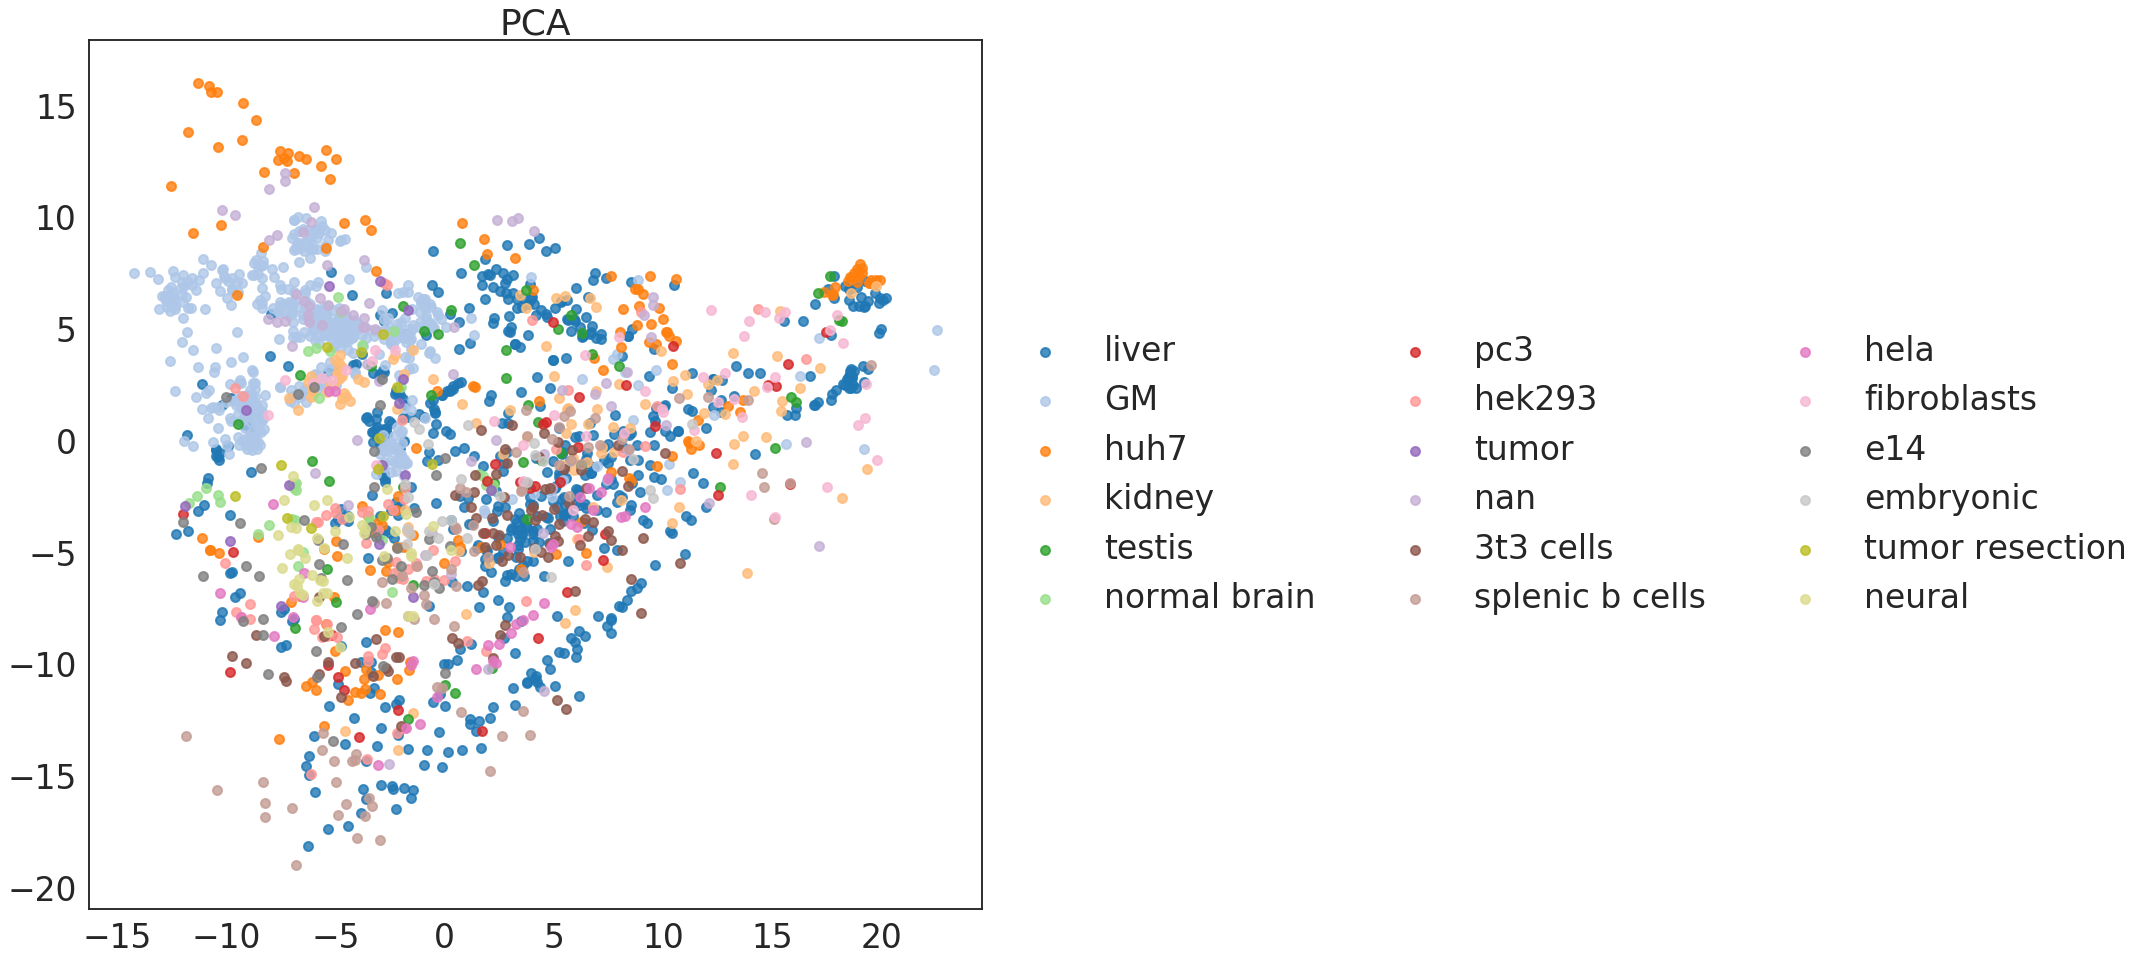

In [31]:
fig, ax = plt.subplots(figsize=(16,16))
#ax.scatter(tr[:,0], tr[:, 1], alpha=0.3)
for tisue_type, color, in palette_colors.items():
    plt.scatter(tr[tissue_types == tisue_type, 0], tr[tissue_types == tisue_type, 1],
                color=color, alpha=.8, lw=2,
                label=tisue_type)
#ax.legend(loc=1, shadow=False, scatterpoints=1, ncol=3, frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3, frameon=False)
ax.set_title('PCA')
fig.tight_layout()

In [24]:
pca = PCA(n_components=2)
X_r = pca.fit(np.log2(np.array(metagene_profile_matrix)+1)).transform(np.log2(np.array(metagene_profile_matrix)+1))


In [25]:
print(pca.explained_variance_ratio_)  


[0.41104582 0.30496344]


In [26]:
palette_colors

{'liver': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'GM': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'huh7': (1.0, 0.4980392156862745, 0.054901960784313725),
 'kidney': (1.0, 0.7333333333333333, 0.47058823529411764),
 'testis': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'normal brain': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'pc3': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'hek293': (1.0, 0.596078431372549, 0.5882352941176471),
 'tumor': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'nan': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 '3t3 cells': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'splenic b cells': (0.7686274509803922,
  0.611764705882353,
  0.5803921568627451),
 'hela': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'fibroblasts': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'e14':

In [ ]:
X_r.shape

In [ ]:
tissue_types

Text(0.5, 1.0, 'PCA')

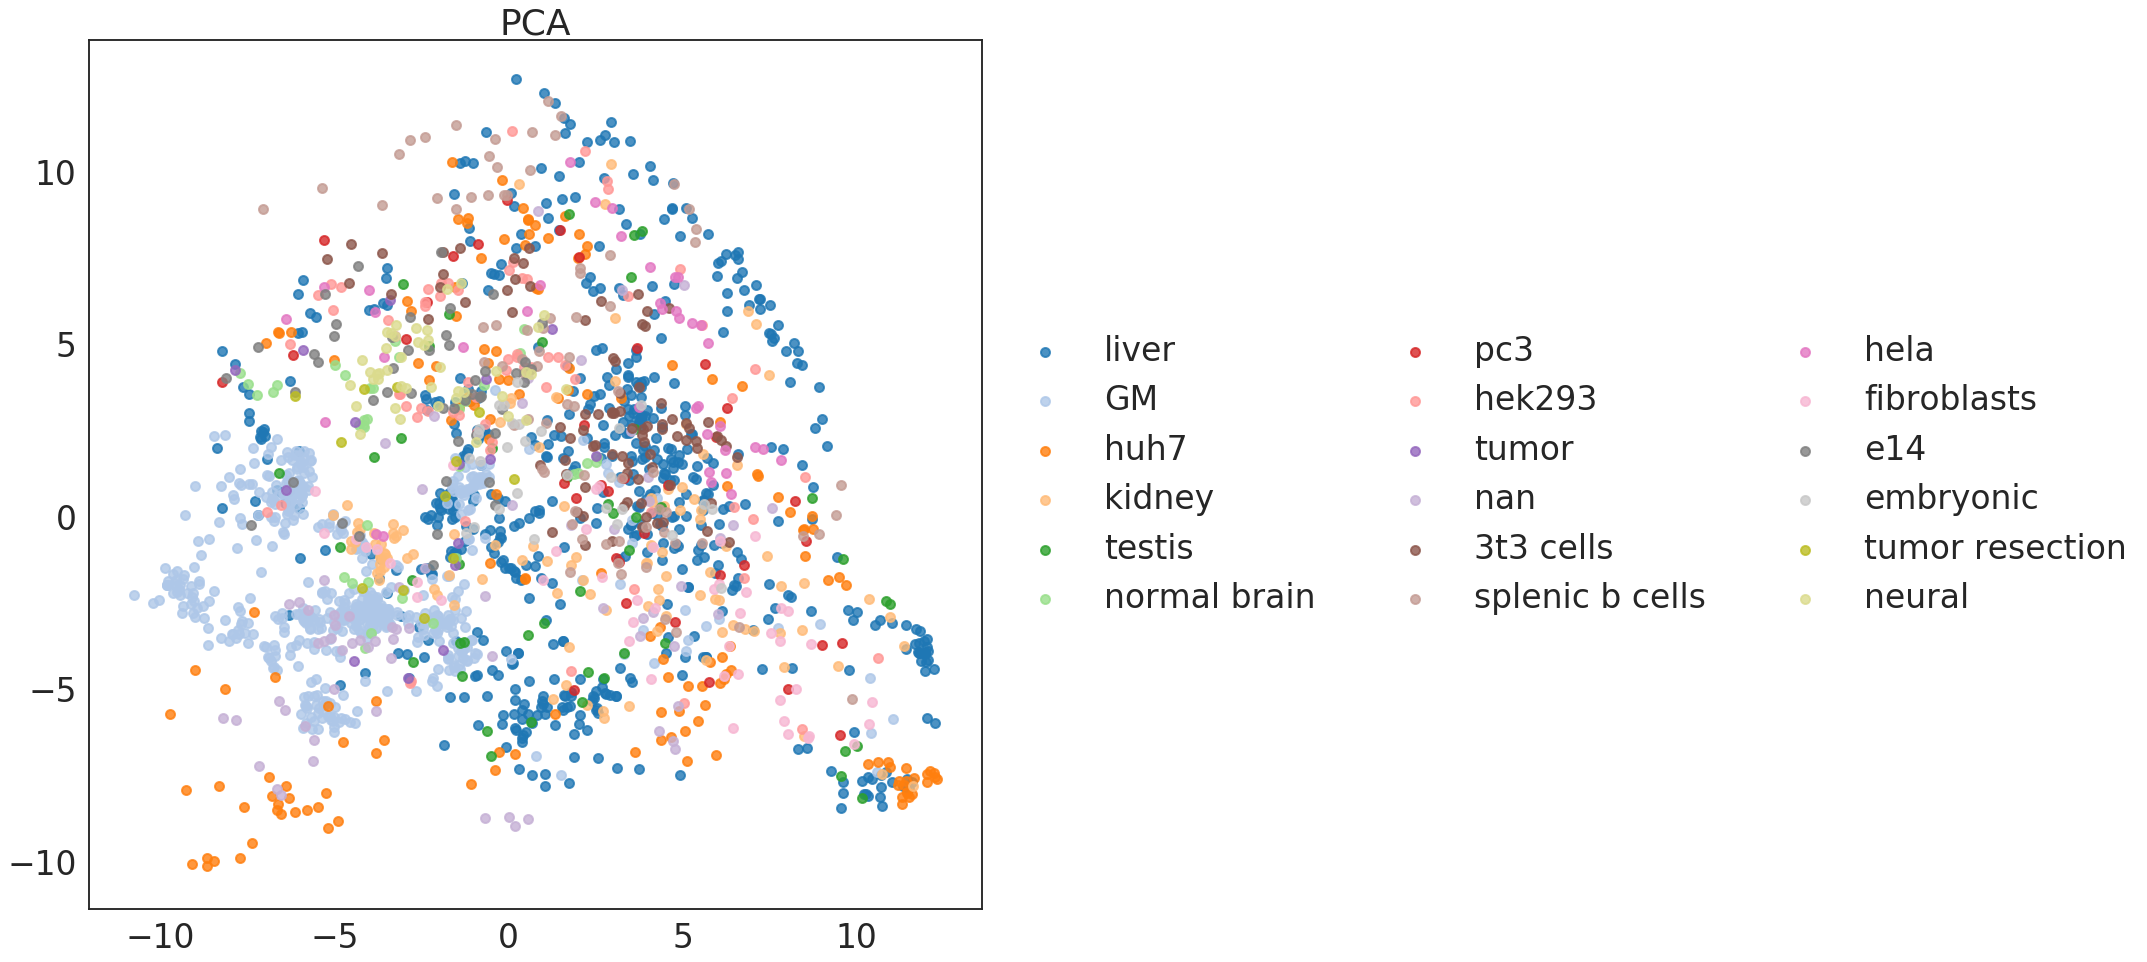

In [30]:
fig, ax = plt.subplots(figsize=(16,16))
for tisue_type, color, in palette_colors.items():
    plt.scatter(X_r[tissue_types == tisue_type, 0], X_r[tissue_types == tisue_type, 1],
                color=color, alpha=.8, lw=2,
                label=tisue_type)
#ax.legend(loc=1, shadow=False, scatterpoints=1, ncol=3, frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3, frameon=False)
ax.set_title('PCA')


In [ ]:
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, METAGENE_DIMENSION)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, METAGENE_DIMENSION)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

index = faiss.IndexFlatL2(METAGENE_DIMENSION)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)


In [1]:
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(xb[:2], k) # sanity check
print(I)
print(D)

NameError: name 'index' is not defined

In [ ]:
xb.shape

In [ ]:
I.shape

In [ ]:
D.shape

In [32]:
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
def dtw(X, Y, metric='euclidean', ddtw=True, ddtw_order=1):
    """
    
    Parameters
    ----------
    X : array_like
        M x D matrix
    Y : array_like
        N x D matrix    
    metric : string
             The distance metric to use. 
             Can be :
             'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
             'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski',
             'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao',
             'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
             'wminkowski', 'yule'.
             See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    ddtw : bool
           Should use derivative DTW where the distance matrix is created 
           using the derivate values at each point rather than the point themselves
    ddtw_order : int [1,2]
                 First order uses one difference method
                 Second order uses np.gradient for an approximation upto second order
    Returns
    -------
    total_cost : float
                 Total (minimum) cost of warping
    pointwise_cost :  array_like
                      M x N matrix with cost at each (i, j)
    accumulated_cost : array_like
                       M x N matrix with (minimum) cost accumulated till (i,j)
                       having started from (0, 0)
        
    """
    X = list(X)
    Y = list(Y)
    X = np.array(X)
    Y = np.array(Y)
    if len(X.shape) == 1:
        # Reshape to N x 1 form
        X = X[:, np.newaxis]
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    # m = X length
    # n = Y length
    m, n = X.shape[0], Y.shape[0]    
    assert X.shape[1] == Y.shape[1]
    d = X.shape[1]
    D = np.zeros((m+1, n+1))
    D[1:, 0] = np.inf
    D[0, 1:] = np.inf
    if not ddtw:
        D[1:,1:] = cdist(X, Y, metric)
    else:
        if ddtw_order == 1:
            X_mod = np.zeros(X.shape)
            Y_mod = np.zeros(Y.shape)
            # shape will be M-1 x D            
            X_diff = np.diff(X, axis=0)
            # shape will be M-1 x D
            Y_diff = np.diff(Y, axis=0)
            
            X_mod[1:m-1, :] = 0.5 *(X_diff[:m-2,:] + 0.5 * X_diff[1:m-1])
            
            Y_mod[1:n-1, :] = 0.5 *(Y_diff[:n-2,:] + 0.5 * Y_diff[1:n-1])
            
            X_mod[0, :] = X_mod[1,:]
            X_mod[m-1, :] = X_mod[m-2,:]
            
            Y_mod[0, :] = Y_mod[1,:]
            Y_mod[n-1, :] = Y_mod[n-2,:]
        elif ddtw_order == 2:
            X_mod = np.gradient(X, axis=0)
            Y_mod = np.gradient(Y, axis=0)
        else:
            raise NotImplemented('Not implemented order {}'.format(ddtw_order))            
        D[1:,1:] = cdist(X_mod, Y_mod, metric)
    pointwise_cost = D[1:,1:].copy()
    for i in range(0, m):
        for j in range(0, n):
            cost = D[i+1, j+1]
            D[i+1, j+1] = cost + min (D[i, j+1], D[i+1, j], D[i, j])           
    accumulated_cost = D[1:, 1:]
    total_cost = D[m, n]/sum(D.shape)
    return total_cost#, pointwise_cost, accumulated_cost

In [ ]:
Z = hac.linkage(metagene_profile_matrix, method='single', metric=dtw)

In [ ]:
Z

In [ ]:
Z = hac.linkage(metagene_profile_matrix, method='single', metric=dtw)